# Validate Selected LGAs

The workflow in this notebook demonstrates how to load and a section of a generated flood map and plot it over the relevant satellite imagery.

For this tutorial, we will load the data for the EMSR586 Copernicus activation.

In [1]:
# Necessary imports
import os
os.environ['USE_PYGEOS'] = '0'
from itertools import product
from dotenv import load_dotenv
import fsspec
import geopandas as gpd
import matplotlib.pyplot as plt

from ml4floods.data import utils
from ml4floods.visualization import plot_utils
from ml4floods.models.postprocess import spatial_aggregation
from ml4floods.data.ee_download import process_metadata

from datetime import datetime, timezone, timedelta
import ee
from georeader.readers import ee_query
import pandas as pd
import folium
#from backports.zoneinfo import ZoneInfo
from zoneinfo import ZoneInfo
import geemap.foliumap as geemap
import shapely

# Uncomment this to suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Load environment and project details

As with the other notebooks, we load credentials and project details from a hidden ```.env``` file.

In [2]:
# Load environment variables (including path to credentials) from '.env' file
env_file_path = "../.env"

assert load_dotenv(dotenv_path=env_file_path) == True, "[ERR] failed to load environment!"
assert "GOOGLE_APPLICATION_CREDENTIALS" in os.environ, "[ERR] missing $GOOGLE_APPLICATION_CREDENTIAL!"
assert "GS_USER_PROJECT" in os.environ, "[ERR] missing $GS_USER_PROJECT!"
key_file_path = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
assert os.path.exists(key_file_path), f"[ERR] Google credential key file does not exist: \n{key_file_path} "
assert "ML4FLOODS_BASE_DIR" in os.environ, "[ERR] missing $ML4FLOODS_BASE_DIR!"
base_path = os.environ["ML4FLOODS_BASE_DIR"]
assert os.path.exists(base_path), f"[ERR] base path does not exist: \n{base_path} "
print("[INFO] Successfully loaded FloodMapper environment.")

[INFO] Successfully loaded FloodMapper environment.


In [3]:
# Authenticate with Google Earth Engine
# Execute 'earthengine authenticate' from a terminal

In [4]:
# Initialise the Google Earth Engine connection.
# Follow instructions on login prompt, if required.
#ee.Initialize()

## Set flood event & validation parameters

Set the session name, flooding date range and LGAs to be validated.

In [5]:
# All work is conducted under a unique session name
session_name = "EMSR586"

# Pre-flood date range
date_pre_flood_start = "2022-06-10"
date_pre_flood_end = "2022-06-20"

# Flooding date range
date_flood_start = "2022-07-01"
date_flood_end = "2022-07-24"
#flood_duration_days = 15

# List of LGAs to check
lga_req_list = ["Newcastle", "Maitland", "Cessnock"]

# Bucket Name
bucket_name = "gs://floodmapper-demo"

## Parse dates, load the grid and LGA shapes

In [6]:
# First parse the pre- and post-flood dates
tz = ZoneInfo("Australia/Sydney")
date_event = datetime.strptime(date_flood_start,"%Y-%m-%d").replace(tzinfo=tz)
period_pre_flood_start = datetime.strptime(date_pre_flood_start,"%Y-%m-%d").replace(tzinfo=tz)
period_pre_flood_end = datetime.strptime(date_pre_flood_end,"%Y-%m-%d").replace(tzinfo=tz)
period_flood_start = datetime.strptime(date_flood_start,"%Y-%m-%d").replace(tzinfo=tz)
period_flood_end = datetime.strptime(date_flood_end,"%Y-%m-%d").replace(tzinfo=tz)

print(f"Pre-flood search period: \n{period_pre_flood_start} to \n{period_pre_flood_end}")
print(f"\nFlood search period: \n{period_flood_start} to \n{period_flood_end}")

Pre-flood search period: 
2022-06-10 00:00:00+10:00 to 
2022-06-20 00:00:00+10:00

Flood search period: 
2022-07-01 00:00:00+10:00 to 
2022-07-24 00:00:00+10:00


gs://floodmapper-demo/0_DEV/1_Staging/operational/grid_australia.geojson


<Axes: >

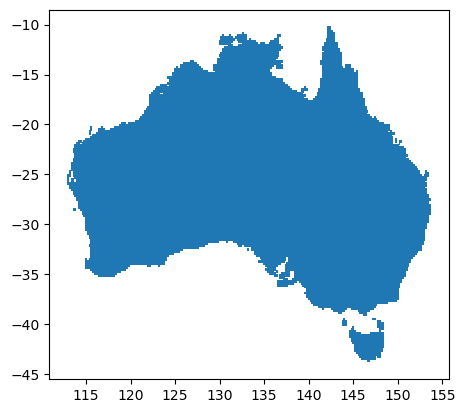

In [7]:
# The sampling grid is stored in a GeoJSON file under the session name
path_to_aois = f"{bucket_name}/0_DEV/1_Staging/operational/grid_australia.geojson"
print(path_to_aois)
grid_fs = utils.get_filesystem(path_to_aois)
grid_df = gpd.read_file(path_to_aois).to_crs('epsg:4326')
grid_df.plot()

<Axes: >

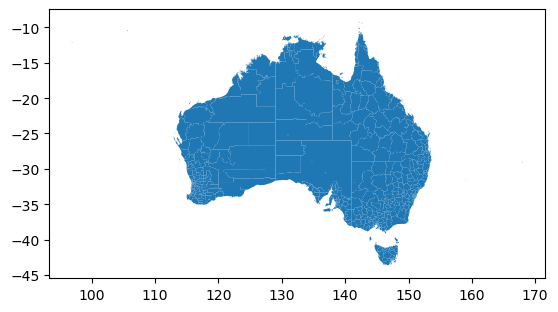

In [8]:
# We store the LGA shapefile locally
lga_file_path = "../resources/LGAs/LGA_2022_AUST_GDA2020.shp"
lga_df = gpd.read_file(lga_file_path).to_crs('epsg:4326')
lga_df.plot()

## Define useful functions

In [9]:
def intersect_lga_grid(lga_name, lga_df, grid_df):
    """Return the grid patches that overlap a LGA/"""
    grid_list = grid_df.overlay(lga_df[lga_df["LGA_NAME22"] == lga_name ], 
                                how = 'intersection').name.to_list()
    grid_lga_df = grid_df.loc[grid_df.name.apply(lambda x: x in grid_list)]
    return grid_list, grid_lga_df

def get_metadata_grid(grid_name, bucket_name):
    """Fetch and parse the metadata for a single grid position."""
    csv_s2_path = f"{bucket_name}/0_DEV/1_Staging/GRID/{grid_name}/S2/s2info.csv"
    print(csv_s2_path)
    metadata_s2 = process_metadata(csv_s2_path)
    metadata_s2["satellite"] = "S2"
    csv_l89_path = f"{bucket_name}/0_DEV/1_Staging/GRID/{grid_name}/Landsat/landsatinfo.csv"
    metadata_l89 = process_metadata(csv_l89_path)
    metadata_l89["satellite"] = "Landsat"
    metadata = pd.concat([metadata_s2, metadata_l89],ignore_index=True)
    metadata.cloud_probability*=100
    metadata = metadata[metadata["valids"] >= .8]
    return metadata

def plot_data_timeseries(metadata, period_flood_start, period_flood_end, period_pre_flood_start):
    """Plot the time-series of available satellite data."""
    for sat, downloaded in product(["Landsat","S2"], [True, False]):
        label=f"{sat} ({'' if downloaded else 'NOT '}Downloaded)"
        selection_mask = (metadata.satellite == sat) & (metadata.s2available == downloaded)
        color = "C0" if sat =="S2" else "C1"
        marker = "o" if downloaded else "x"
        ax.scatter(x=metadata[selection_mask].datetime, 
                   y=metadata[selection_mask].cloud_probability, 
                   label=label, c=color, marker=marker, s=100)
        
    # Format plot to look nice
    ax.legend()
    metadata.plot(x="datetime", y="cloud_probability", ax=ax,legend=None)
    ax.axvspan(period_flood_start, period_flood_end, alpha=0.2)
    datespan = abs(period_flood_end - period_pre_flood_start)
    ax.set_xlim(period_pre_flood_start-datespan*.1, period_flood_end+datespan*.1)
    plt.ylabel("Mean Cloud Coverage (%)")
    plt.xlabel("")
    plt.grid()

def create_aggregate_floodmap(grid_fs, grid_list, bucket_name):
    """Create a mosaiced floodmap covering the specified grid patches."""
    floodmaps_aggregate = []
    floodmaps_aggregate = ["gs://" 
                           + grid_fs.glob(f"{bucket_name}/0_DEV/1_Staging"
                                          + f"/operational/{session_name}/{g}"
                                          + f"/pre_post_products/postflood*.geojson")[0]
                           for g in grid_list]
    floodmap = spatial_aggregation(floodmaps_aggregate)
    return floodmap

def query_ee_images(poly_outline, period_start, period_end):
    """
    Query GEE for available images in a spatial region and date range.
    Return a dataframe of available images and an image collection.
    """
    images_available, collection = \
    ee_query.query(poly_outline, 
                   period_start, 
                   period_end,
                   producttype="both",                                
                   return_collection=True)
    return images_available, collection

def build_interactive_map(bucket_name, grid_outline, floodmap, images_available_gee, 
                          images_available_gee_pre, do_plot_day=False):
    """Build an interactive Folium map to visualise the LGA."""
    
    # Create a clipping Geometry
    eegeom_clip = ee.Geometry(shapely.geometry.mapping(grid_outline))
    # Filter for cloud polygons
    clouds = floodmap.loc[floodmap['class'].apply(lambda x: x in ['cloud'])]
    # Filter for 'flood_trace' and 'water' polygons
    floodmap_post_intersect = floodmap.loc[floodmap['class']
                                           .apply(lambda x: x in ['flood_trace', 'water'])]
    # Initialise the map base layer at the LGA centroid
    m = geemap.Map(location=grid_outline.centroid.coords[0][-1::-1], zoom_start=10)
    # Load the pre-flood images
    for (day, satellite), images_day in images_available_gee_pre.groupby(["solarday", "satellite"]):
        image_col_day_sat = \
        collection_pre.filter(ee.Filter.inList("title", images_day.index.tolist())).map(lambda x: x.clip(eegeom_clip))
        bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
        m.addLayer(image_col_day_sat,
                   {"min":0, "max":3500 if satellite.startswith("S2") else 0.35, "bands":bands},
                   f"{satellite}: {day}", 
                   False)
    # Load the post-flood images and post-flood maps
    for (day, satellite), images_day in images_available_gee.groupby(["solarday", "satellite"]):
        image_col_day_sat = \
        collection.filter(ee.Filter.inList("title", images_day.index.tolist())).map(lambda x: x.clip(eegeom_clip))
        bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
        m.addLayer(image_col_day_sat, 
                   {"min":0, "max":3000 if satellite.startswith("S2") else 0.3, "bands":bands},
                   f"{satellite}: {day}", 
                   False)
        satellite_plot = 'S2' if satellite.startswith("S2") else 'Landsat'
        if do_plot_day:
            print(f'Aggregating floodmap for day {day} and {satellite_plot} images')
            try:
                floodmaps_aggregate = []
                for g in grid_list:
                    floodmaps_aggregate.extend(["gs://" 
                                                + f for f in grid_fs.glob(f"{bucket_name}/0_DEV/1_Staging"
                                                + f"/GRID/{g}/WF2_*_vec/{satellite_plot}/{day}.geojson") ])
                floodmap_day_sat = spatial_aggregation(floodmaps_aggregate)   
                floodmap_day_sat = floodmap_day_sat.loc[floodmap_day_sat['class']
                                                        .apply(lambda x: x in ['flood_trace', 'water'])]
                floodmap_day_sat.explore(m=m, name = f'Water map {satellite_plot} {day}', color = 'violet')
            except:
                continue
        
    # Format the map and add controls
    #m.addLayer(eegeom_clip, name="AOI", color="red", style_kwds={"fillOpacity": 0.0})
    floodmap_post_intersect.explore(m=m, name="Water Post-Flood", color="violet")
    clouds.explore(m=m, name="Clouds", color="gray")
    folium.LayerControl(collapsed=False).add_to(m)
    return m

## Newcastle

Explore the Newcastle LGA and visualise available data.

In [10]:
# Choose Newcastle (LGA[0]) and fetch the grid polygons covering the LGA
lga_name = lga_req_list[0]
grid_list, grid_lga_df = intersect_lga_grid(lga_name, lga_df, grid_df)
grid_lga_df.explore(style_kwds={"fillOpacity": 0.3})

/Users/cpurcell/opt/miniconda3/envs/floodmapper/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


**Visualise data availability in a representative grid patch**

For Newcastle choose GRID32842

In [ ]:
# Choose a representative grid from the map above
grid_name = "GRID32842"

# Fetch the metadata from the bucket (FIXME!)
#metadata = get_metadata_grid(grid_name, bucket_name)
#print(f"There are {metadata.shape[0]} entries in the table.")
#metadata.head(5)

In [ ]:
# Plot the timeseries of data (FIXME)
#fig, ax = plt.subplots(1,1, figsize=(15,5))
#plot_data_timeseries(metadata, period_flood_start, period_flood_end, period_pre_flood_start)

**Create the aggregate flood map and explore**

In [11]:
# Create an aggregate floodmap from the images in GCP
floodmap = create_aggregate_floodmap(grid_fs, grid_list, bucket_name)
plot_utils.plot_floodmap(floodmap)                 

IndexError: list index out of range

In [ ]:
# Create an outline of the gridded LGA to query data
grid_outline = grid_lga_df.dissolve().geometry.values[0]
grid_outline

In [ ]:
# Check for images covering the flood period 
images_available_gee, collection = \
    query_ee_images(grid_outline,
                    period_flood_start,
                    period_flood_end)

# Check for images before flood period 
images_available_gee_pre, collection_pre = \
    query_ee_images(grid_outline,
                    period_pre_flood_start,
                    period_pre_flood_end)

assert images_available_gee.shape[0] > 0, "[ERR] No images found for date and location!"
print("Total images available:", images_available_gee.shape[0])

In [ ]:
# Build a Folium map
m = build_interactive_map(bucket_name, grid_outline, floodmap, images_available_gee, images_available_gee_pre,
                         do_plot_day=True)

In [ ]:
# Display the map
m